**Background Information**

Customer churn is a significant challenge in the telecom industry. Identifying customers who are
likely to churn is crucial for implementing proactive measures to retain them. By leveraging PySpark,
we can take advantage of its distributed computing capabilities to handle large volumes of data
efficiently and build an accurate machine learning model for churn prediction.

**Problem Statement**

The goal of this project is to develop a machine learning model using PySpark that accurately
predicts customer churn in a telecom company. The model should achieve a minimum accuracy of
0.8, enabling the company to proactively identify and retain customers at risk of leaving. By
effectively predicting churn, the company can implement targeted retention strategies, reduce
customer attrition, and improve overall business performance.


In [1]:
#install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=7b7dc5ae4dc2c87f1f64406e3c2e324f753f3a222f064f30a9d300f24962fdc5
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [17]:
#Import the libraries
from pyspark.sql.session import SparkSession
from pyspark import SparkContext
import os
import urllib.request
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator,TrainValidationSplit
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, MinMaxScaler


In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

In [4]:
# load dataset
df = spark.read.csv('telecom_dataset.csv', header=True)
df.show()

+----------+------+---+--------------+--------------+------------+-----+
|CustomerID|Gender|Age|      Contract|MonthlyCharges|TotalCharges|Churn|
+----------+------+---+--------------+--------------+------------+-----+
|         1|Female| 25|Month-to-Month|          65.7|       156.5|   No|
|         2|  Male| 37|      One Year|          89.0|      2356.8|   No|
|         3|  Male| 52|      Two Year|         115.5|      5408.6|   No|
|         4|Female| 30|Month-to-Month|          75.9|       129.4|  Yes|
|         5|  Male| 45|      One Year|          98.2|      3142.0|   No|
|         6|Female| 55|      Two Year|          99.9|      6541.5|   No|
|         7|  Male| 32|Month-to-Month|          82.1|       267.7|  Yes|
|         8|Female| 28|Month-to-Month|          61.5|       346.9|   No|
|         9|  Male| 48|      One Year|         101.8|      5149.6|  Yes|
|        10|Female| 60|      Two Year|         108.1|      6742.8|  Yes|
|        11|  Male| 42|Month-to-Month|          78.

In [5]:
print((df.count(), len(df.columns)))

(20, 7)


Our dataframe has 7 columns and 20 rows

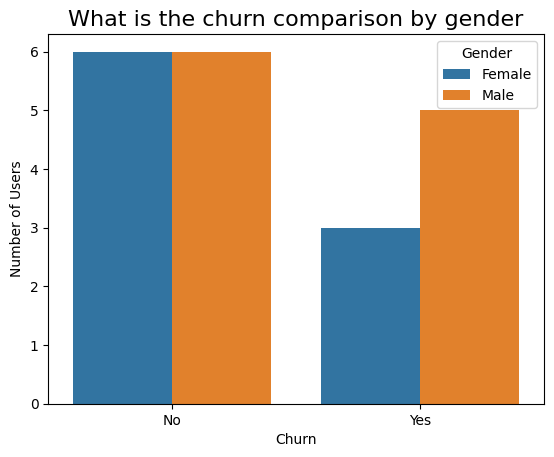

In [6]:
#Explore churn by gender
import seaborn as sns

df_churn_by_gender = df.select(["CustomerID", "Gender","Churn"]).groupby(["Churn", "Gender"]).count().sort("Churn").toPandas()

#Plot a barplot
sns.barplot(x='Churn', y='count', hue='Gender', data=df_churn_by_gender)
plt.title('What is the churn comparison by gender', fontsize= 16);
plt.xlabel('Churn');
plt.ylabel('Number of Users');

**Data Preprocessing:** Perform necessary preprocessing steps on the dataset, including handling missing values, feature scaling, encoding categorical variables, and splitting the data into training and testing sets. Consider using PySpark's DataFrame API for efficient data manipulation.


In [7]:
# Drop null values
df = df.na.drop()

# Verify the result
print("Df has: {} rows, {} columns".format(df.count(), len(df.columns)))

Df has: 20 rows, 7 columns


In [8]:
#Drop duplicates
df = df.dropDuplicates()

# Verify the result
print("Shape of DataFrame: {} rows, {} columns".format(df.count(), len(df.columns)))

Shape of DataFrame: 20 rows, 7 columns


In [9]:
# Convert some columns from string to integer type and float types
df1 = df.withColumn("Age", col("Age").cast("integer"))

df2 = df1.withColumn("MonthlyCharges", col("MonthlyCharges").cast("float"))

df3 = df2.withColumn("TotalCharges", col("TotalCharges").cast("float"))

df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Contract: string (nullable = true)
 |-- MonthlyCharges: float (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Churn: string (nullable = true)



**Feature Engineering:** Create new features from the existing dataset that might be helpful for predicting churn. For example, you could calculate metrics such as call duration, average monthly spend, customer tenure, or customer satisfaction scores.


In [10]:
#Group ages by creating a new column that will categorize each age into a group

grouped_df = df3.withColumn(
    'Age_group',
    F.when((F.col('Age') >= 0) & (F.col('Age') < 5), '0-4')
    .when((F.col('Age') >= 5) & (F.col('Age') < 10), '5-9')
    .when((F.col('Age') >= 10) & (F.col('Age') < 15), '10-14')
    .when((F.col('Age') >= 15) & (F.col('Age') < 20), '15-19')
    .when((F.col('Age') >= 20) & (F.col('Age') < 25), '20-24')
    .when((F.col('Age') >= 25) & (F.col('Age') < 30), '25-29')
    .when((F.col('Age') >= 30) & (F.col('Age') < 35), '30-34')
    .when((F.col('Age') >= 35) & (F.col('Age') < 40), '35-39')
    .when((F.col('Age') >= 40) & (F.col('Age') < 45), '40-44')
    .when((F.col('Age') >= 45) & (F.col('Age') < 50), '45-49')
    .when((F.col('Age') >= 50) & (F.col('Age') < 55), '50-54')
    .when((F.col('Age') >= 55) & (F.col('Age') < 60), '55-59')
    .when((F.col('Age') >= 60) & (F.col('Age') < 65), '60-64')
    .otherwise('65+')
)

grouped_df.show()

+----------+------+---+--------------+--------------+------------+-----+---------+
|CustomerID|Gender|Age|      Contract|MonthlyCharges|TotalCharges|Churn|Age_group|
+----------+------+---+--------------+--------------+------------+-----+---------+
|        16|  Male| 47|      Two Year|         112.3|      5432.0|  Yes|    45-49|
|        20|  Male| 39|      Two Year|          97.1|      3992.4|   No|    35-39|
|        17|Female| 26|Month-to-Month|          68.2|       289.1|   No|    25-29|
|        11|  Male| 42|Month-to-Month|          78.9|       547.6|   No|    40-44|
|        18|  Male| 33|Month-to-Month|          75.5|       462.5|  Yes|    30-34|
|         7|  Male| 32|Month-to-Month|          82.1|       267.7|  Yes|    30-34|
|         4|Female| 30|Month-to-Month|          75.9|       129.4|  Yes|    30-34|
|         8|Female| 28|Month-to-Month|          61.5|       346.9|   No|    25-29|
|        10|Female| 60|      Two Year|         108.1|      6742.8|  Yes|    60-64|
|   

In [23]:
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
contract_indexer = StringIndexer(inputCol="Contract", outputCol="ContractIndex")
churn_indexer = StringIndexer(inputCol="Churn", outputCol="label")

indexers = [gender_indexer, contract_indexer, churn_indexer]
pipeline = Pipeline(stages=indexers)
df5 = pipeline.fit(df3).transform(df3)


assembler = VectorAssembler(inputCols=["GenderIndex", "Age", "ContractIndex", "MonthlyCharges", "TotalCharges"], outputCol="features")


df5 = assembler.transform(df5)

In [14]:
# Split the data into training and testing sets
train_data, test_data = df5.randomSplit([0.8, 0.2], seed=42)

**Model Selection and Training:**

Choose an appropriate machine learning algorithm for churn
prediction, considering the nature of the problem and the dataset characteristics. PySpark
provides various algorithms such as logistic regression, random forests, gradient boosting,
and support vector machines. Experiment with different models and hyperparameter
configurations to achieve the desired accuracy of 0.8.

In [15]:
models = [
    RandomForestClassifier(labelCol="label", featuresCol="features", seed=42),
    LogisticRegression(labelCol="label", featuresCol="features")
]

In [16]:
paramGrids = [
    ParamGridBuilder().addGrid(RandomForestClassifier.maxDepth, [5, 10]).build(),
    ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.01, 0.1]).build()
]

accuracies = []

In [19]:
# Training the models
for i in range(len(models)):
    model = models[i]
    paramGrid = paramGrids[i]

    evaluator = BinaryClassificationEvaluator(labelCol="label")
    tvs = TrainValidationSplit(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator)

    tvs_model = tvs.fit(train_data)



In [28]:
lr_best = LogisticRegression(labelCol="label", featuresCol="features")
lr_best.setParams(aggregationDepth=2,
                  elasticNetParam=0.5,
                  family="auto",
                  fitIntercept=True,
                  maxIter=100,
                  regParam=0.01,
                  standardization=True,
                  threshold=0.5,
                  tol=1e-06)

best_model = lr_best.fit(train_data)

In [29]:
#Make predictions from the model

predictions = tvs_model.transform(test_data)
predictions_best = best_model.transform(test_data)

In [32]:
# Evaluating the model performance
evaluator = MulticlassClassificationEvaluator(labelCol="label")

accuracy_lr = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision_lr = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall_lr = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_lr = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Logistic Regression accuracy:", accuracy_lr)
print("Logistic Regression Precision:", precision_lr)
print("Logistic Regression recall:", recall_lr)
print("Logistic Regression F1-score:", f1_lr)

Logistic Regression accuracy: 0.6
Logistic Regression Precision: 0.8
Logistic Regression recall: 0.6000000000000001
Logistic Regression F1-score: 0.5666666666666667


In [26]:

accuracy = evaluator.evaluate(predictions)
accuracies.append(accuracy)

print("Model", i+1, "Accuracy:", accuracy)

Model 2 Accuracy: 1.0


**Findings**
With logistic regression we are able to meet the minimum accuracy of **0.8**, where our highest score is a **1.0** and a Precision of **0.8** against the RandomForestClassifier.